In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, lr_scheduler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc
import torch.nn.functional as F
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from PIL import Image  
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as transf
from skimage.util import random_noise
import torch
from numpy.random import choice
from sklearn.linear_model import LassoCV, ElasticNetCV
import joblib
from skimage.transform import resize
from torchvision import models, transforms
import tqdm
from tqdm import tqdm_notebook as tqdm
import SimpleITK as sitk
from transformation_3d import *


ModuleNotFoundError: No module named 'calculate_disparity'

In [ ]:
dataframe = pd.read_csv("../ADNI/B1_correction_new.csv") # 記錄每張MRI影像的metadata
img_data = os.listdir("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction/")# 這邊的img是已經將mask與MRI做結合的圖片
img_data_mask = os.listdir("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction__Mask/")# 這邊的img是已經將mask與MRI做結合的圖片



In [ ]:
def find_mask_idx(ID):
    for i, j in enumerate(img_data_mask):
        img_ID = j[j.rindex('_S')+1:j.rindex('_I')]
        if (img_ID == ID):
            return i

In [ ]:
def transformation(img, rand):
    
    img_np = np.copy(img)
    
    if (rand == 0):
        img_np = shear(img_np)
    elif (rand == 1):
        img_np = rotation(img_np)
    elif (rand == 2):
        img_np = fish(img_np, 0.4)
    else:
        img_np = scale(img_np)
    
    return img_np

In [ ]:
count = 0

np.random.seed(2021)

for i, data in enumerate(img_data):
        
    img_filename = data
    img_ID = img_filename[img_filename.rindex('_S')+1:img_filename.rindex('_I')]
    
    mask_idx = find_mask_idx(img_ID)
    
    mask_filename = img_data_mask[mask_idx]
    img_ID_mask = mask_filename[mask_filename.rindex('_S')+1:mask_filename.rindex('_I')]
    
    sitk_img = sitk.ReadImage('../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction/' + img_filename)
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask = sitk.ReadImage('../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction__Mask/' + mask_filename)
    resampled_mask_img = sitk.GetArrayFromImage(sitk.Resample(sitk_mask, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask.GetPixelID()))
            
    img = mask_img(img, resampled_mask_img)
    
    img = np.flip(np.moveaxis(img, [0, 1, 2], [2, 1, 0]), axis=1)

    image = crop(img)

    image = torch.from_numpy(image)
    
    image_crop = resize(image, (256, 256, 256))
    
    path = "../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/" + img_filename  
    
    image_crop_saved = nib.Nifti1Image(image_crop, np.eye(4))
    nib.save(image_crop_saved, path) #save new image     

In [3]:
np.random.seed(2021)

img_data = os.listdir("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/")# 這邊的img是已經將mask與MRI做結合的圖片

for i, data in enumerate(img_data):
        
    img_filename = data
    
    image_crop = load_img("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/" + img_filename) 
    
    rand = np.random.randint(0, 4, 1)
    
    image_aug = transformation(image_crop, rand)
    
    path = "../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_aug/" + img_filename 
    
    image_aug = resize(image_aug, (256, 256, 256))

    image_aug_saved = nib.Nifti1Image(image_aug, np.eye(4))
    nib.save(image_aug_saved, path) #save new image  

In [100]:
img_np = load_img("../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_aug/" + img_filename)

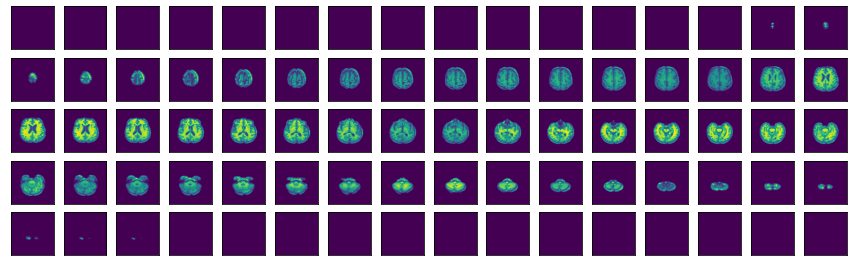

In [101]:
for i in range(img_np.shape[0]):
    plt.subplot(16, 16, i+1)
    fig = plt.imshow(img_np[i, :, :])

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.gcf().set_size_inches(15,15)
plt.show()

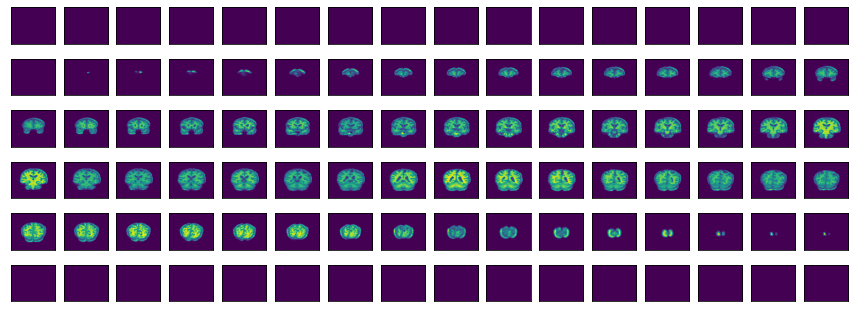

In [102]:
for i in range(img_np.shape[1]):
    plt.subplot(16, 16, i+1)
    fig = plt.imshow(img_np[:, i, :])

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.gcf().set_size_inches(15,15)
plt.show()

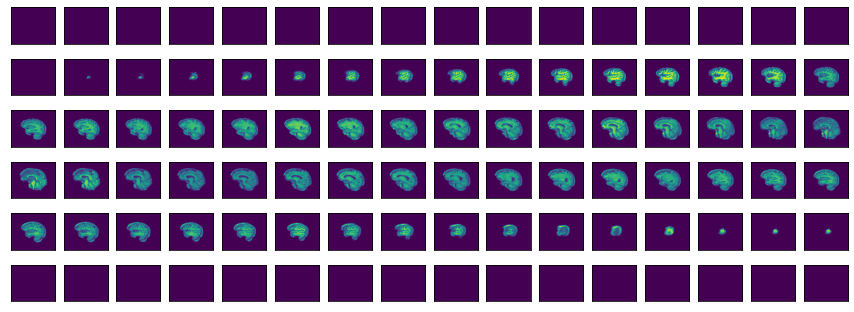

In [103]:
for i in range(img_np.shape[2]):
    plt.subplot(16, 16, i+1)
    fig = plt.imshow(img_np[:, :, i])

    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

    plt.gcf().set_size_inches(15,15)
plt.show()

In [ ]:
np.random.seed(2021)

for i in img_data:
    img = load_img('../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/' + i)
    
    rand = np.random.randint(0, 4)
    image = transform(rand, img)
    
    
    path = '../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_aug/' + i
    
    image = nib.Nifti1Image(image, np.eye(4))
    nib.save(image, path) #save new image

In [5]:
train_list = np.unique(pd.read_csv('train_set.csv')['Subject'].values)
test_list = np.unique(pd.read_csv('test_set.csv')['Subject'].values)
val_list = np.unique(pd.read_csv('val_set.csv')['Subject'].values)

In [121]:
df = pd.DataFrame(columns=['ImageID', 'SubjectID', 'Group', 'Sex', 'Age', 'Race', 'Split', 'Filename'])
count = 0
for i in img_data:
    subject_ID = i[5:15]
    a = i[:-4]
    img_ID = a[a.rindex('_')+1:]
    
#     race = get_race(subject_ID)
    
#     print(race, subject_ID)
    
#     continue
    
    temp_df = dataframe.loc[dataframe['Subject'] == subject_ID]
    
    if (temp_df.empty):
        continue
    else:
        race = get_race(subject_ID)
        img_df = temp_df.loc[temp_df['Image Data ID']==img_ID]
        if (subject_ID in train_list):
            split = 'train'
        elif (subject_ID in test_list):
            split = 'test'
        elif (subject_ID in val_list):
            split = 'val'
        else:
            continue
            
        if (img_df.empty):
            group = temp_df['Group'].values[0]
            sex = temp_df['Sex'].values[0]
            age = np.mean(temp_df['Age'].values)
        else:
            group = img_df['Group'].values[0]
            sex = img_df['Sex'].values[0]
            age = img_df['Age'].values[0]
            
        filename = "../../../mnt/usb/kuopc/ADNI_B1/MPR__GradWarp__B1_Correction_crop/" + i
        single_df = pd.DataFrame({'ImageID':img_ID, 'SubjectID':subject_ID, 'Group':group, 'Sex':sex, 'Age':age, 'Split':split, 'Filename':filename}, index=[count])
        df = df.append(single_df)
        count += 1
        
df.to_csv('data.csv')

In [8]:
df = df.loc[df['Group'] != 'MCI']

df['Group'].value_counts()/len(df)

CN    0.628452
AD    0.371548
Name: Group, dtype: float64

In [9]:
df.loc[df['Split']=='train', 'Group'].value_counts()/len(df.loc[df['Split']=='train'])

CN    0.633495
AD    0.366505
Name: Group, dtype: float64

In [10]:
df.loc[df['Split']=='test', 'Group'].value_counts()/len(df.loc[df['Split']=='test'])

CN    0.588235
AD    0.411765
Name: Group, dtype: float64

In [11]:
df.loc[df['Split']=='val', 'Group'].value_counts()/len(df.loc[df['Split']=='val'])

CN    0.646739
AD    0.353261
Name: Group, dtype: float64

In [ ]:
def get_RID(row):
    race = np.unique(df_demo.loc[df_demo['RID']==row['RID'], 'PTRACCAT'].values)
    
    race = race[~np.isnan(race)]
    
    idx = np.where(race==-4)[0]
    if (len(idx) > 0):
        race = np.delete(race, idx)
        
    if (len(race) > 1):
        
    
    return race

def get_race(row):
    race = row['Race']
    
    if (race == 1 or race == 3 or race == 6 or race == 7):
        return 3
    elif (race == 4):
        return 1
    elif (race == 5):
        return 0
    elif (race == 2):
        return 2
    else:
        return 3

dataframe['Race'] = dataframe.apply (lambda row: get_RID(row), axis=1)
dataframe['Race'] = dataframe.apply (lambda row: get_race(row), axis=1)

In [ ]:
1=American Indian or Alaskan Native; 2=Asian; 3=Native Hawaiian or Other Pacific Islander; 4=Black or African American; 5=White; 6=More than one race; 7=Unknown


# asian - 2
# black - 1
# white - 0
# others - 3



In [58]:
dataframe['Race'].value_counts()

0    2376
1     137
2      32
3      11
Name: Race, dtype: int64

In [60]:
dataframe.to_csv("B1_correction_new.csv")

In [ ]:
df = pd.read_csv('data.csv')

train_list = np.unique(pd.read_csv('train_set.csv')['Subject'].values)
test_list = np.unique(pd.read_csv('test_set.csv')['Subject'].values)
val_list = np.unique(pd.read_csv('val_set.csv')['Subject'].values)

for i, r in df.iterrows():
    subject_ID = r['SubjectID']
    
    if (subject_ID in train_list):
        df.at[i, 'Split'] = 'train'
    elif (subject_ID in test_list):
        df.at[i, 'Split'] = 'test'
    elif (subject_ID in val_list):
        df.at[i, 'Split'] = 'val'
    else:
        continue
        
df.to_csv('data.csv', index=False)

In [ ]:
df = pd.read_csv('data.csv')

id_list = df['SubjectID'].unique()

In [4]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(id_list, test_size=0.2, random_state=2021)
train_list, val_list = train_test_split(train_list, test_size=0.2, random_state=2021)

for i, r in df.iterrows():
    subject_ID = r['SubjectID']
    
    if (subject_ID in train_list):
        df.at[i, 'Split'] = 'train'
    elif (subject_ID in test_list):
        df.at[i, 'Split'] = 'test'
    elif (subject_ID in val_list):
        df.at[i, 'Split'] = 'val'
    else:
        continue
        
df.to_csv('data_new.csv', index=False)

In [12]:
df = pd.read_csv('data.csv')